# LDA Topic Analysis to classify 10k Section 1A Risk Factors

In [87]:
import pandas as pd
import pickle

df = pd.read_pickle('10kData_Final.pkl')
df['texts'] = df['texts'].astype(str) # assert string type
df['year'] = pd.to_datetime(df['periodOfReport'],format='mixed').dt.year

In [88]:
df.head(1)

,id,accessionNo,cik,ticker,companyName,companyNameLong,formType,description,filedAt,linkToTxt,...,linkToFilingDetails,entities,documentFormatFiles,dataFiles,seriesAndClassesContractsInformation,periodOfReport,effectivenessDate,texts,items,year
0,13a511178486ee6f5f4285bbead8f497,0001640147-23-000030,1640147,SNOW,Snowflake Inc.,Snowflake Inc. (Filer),10-K,Form 10-K - Annual report [Section 13 and 15(d...,2023-03-29T16:15:47-04:00,https://www.sec.gov/Archives/edgar/data/164014...,...,https://www.sec.gov/Archives/edgar/data/164014...,"[{'companyName': 'Snowflake Inc. (Filer)', 'ci...","[{'sequence': '1', 'description': '10-K', 'doc...","[{'sequence': '11', 'description': 'XBRL TAXON...",[],2023-01-31,NaN,ITEM 1A. RISK FACTORS \n\nOur operations and ...,NaN,2023


### Sample Used

In [89]:
df[['ticker','texts']].groupby('ticker').count().T

ticker,AAPL,CRM,CSCO,IBM,INTC,META,NVDA,SNOW,TWTR,VMW
texts,10,10,10,10,10,10,10,7,9,10


## Step 1: Pre-Pre Processing
### Trying to filter on paragraphs which represent a risk statement
### Save risk statements into "risks" column

In [90]:
# Limiting to paragraphs 40 char or longer to get rid of the subsection titles and footers etc.
import re

for index, row in df.iterrows():
    texts = row['texts']
    texts = re.sub(r'&#\d+;', '', texts)  # remove the special chars
    text = texts.split('\n')
    filtered_paragraphs = [sentence for sentence in text if len(sentence) > 40]
    filtered_text = '\n'.join(filtered_paragraphs)
    df.loc[index,'risks'] = filtered_text

In [91]:
df.head(1)

,id,accessionNo,cik,ticker,companyName,companyNameLong,formType,description,filedAt,linkToTxt,...,entities,documentFormatFiles,dataFiles,seriesAndClassesContractsInformation,periodOfReport,effectivenessDate,texts,items,year,risks
0,13a511178486ee6f5f4285bbead8f497,0001640147-23-000030,1640147,SNOW,Snowflake Inc.,Snowflake Inc. (Filer),10-K,Form 10-K - Annual report [Section 13 and 15(d...,2023-03-29T16:15:47-04:00,https://www.sec.gov/Archives/edgar/data/164014...,...,"[{'companyName': 'Snowflake Inc. (Filer)', 'ci...","[{'sequence': '1', 'description': '10-K', 'doc...","[{'sequence': '11', 'description': 'XBRL TAXON...",[],2023-01-31,NaN,ITEM 1A. RISK FACTORS \n\nOur operations and ...,NaN,2023,Our operations and financial results are subje...


## Step 2: Pre Processing
### Iterates through each row named "Risks" that was created last step to clean and return noun features

In [92]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions


stopWords = stopwords.words('english')
stopWords.extend(['risk','risks','could','result','business'])

lemmatizer = WordNetLemmatizer()


cleaned_samples = []

# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    
    sample_text = row['risks'].split('\n')
    
    cleaned_sample =[]
    
    for p in sample_text:
        p = re.sub(r'&#\d+;', '', p)
        p = contractions.fix(p)
        words = nltk.word_tokenize(p)
        tagged_words = nltk.pos_tag(words)
        nouns = [word for word, pos in tagged_words if pos.startswith('NN')]
        nouns = [w for w in nouns if w not in stopWords]
        nouns = [w for w in nouns if len(w) > 3]
        nouns = [lemmatizer.lemmatize(w) for w in nouns]
        nouns = [w for w in nouns if w.isalpha()]
        nouns = ' '.join(nouns)
        cleaned_sample.append(nouns)
    
    cleaned_samples.append('\n'.join(cleaned_sample))

# Add the cleaned text to the DataFrame as a new column
df['cleaned_risks'] = cleaned_samples

# Display the DataFrame with cleaned text
display(df['cleaned_risks'].head(10))

0    operation result uncertainty uncertainty infor...
1    operation result uncertainty uncertainty infor...
2    operation result uncertainty uncertainty infor...
3                                                     
4    operation result uncertainty position result o...
5    operation result uncertainty position result o...
6    operation result uncertainty position result o...
7    Certain factor effect condition result operati...
8    Certain factor effect condition result operati...
9    Certain factor effect condition result operati...
Name: cleaned_risks, dtype: object

In [93]:
print(stopWords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [94]:
print(df['risks'][1])

Our operations and financial results are subject to various risks and uncertainties, including those described below. You should consider and read carefully all of the risks and uncertainties described below, together with all of the other information contained in this Annual Report on Form 10-K, including the section titled Managements Discussion and Analysis of Financial Condition and Results of Operations and our consolidated financial statements and related notes, before making an investment decision. The risks described below are not the only ones we face. The occurrence of any of the following risks or additional risks and uncertainties not presently known to us or that we currently believe to be immaterial could materially and adversely affect our business, financial condition, or results of operations. In such case, the trading price of our common stock could decline. You should not interpret our disclosure of any of the following risks to imply that such risks have not already

In [95]:
print(df['cleaned_risks'][1])

operation result uncertainty uncertainty information Report Form section Managements Discussion Analysis Financial Condition Results Operations statement note investment decision one occurrence uncertainty condition result operation case trading price stock disclosure
Risks Business Operations
revenue growth performance operating history result operation
revenue year January revenue growth quarterly period indication performance growth operating history ability result operation revenue performance obligation percentage revenue period number uncertainty ability growth platform consumption revenue growth performance
period revenue growth revenue number reason demand platform competition change technology change software infrastructure decrease growth market failure reason advantage growth opportunity revenue growth period revenue growth rate period decline revenue growth rate investor perception trading price stock uncertainty company industry uncertainty assumption uncertainty future re

# Step 3: Run the LDA Model
### Explode the rows which contain the cleaned risks separated by new line
### Fit the TFIDF on every risk in the corpus
### Fit the LDA model on every risk in the corpus in order to find the best classes

In [96]:
cleaned_sample = df['cleaned_risks'].str.split('\n').explode().tolist()
print(cleaned_sample)

['operation result uncertainty uncertainty information Report Form section Managements Discussion Analysis Financial Condition Results Operations statement note investment decision one occurrence uncertainty condition result operation case trading price stock disclosure', 'Risks Business Operations', 'revenue growth performance operating history result operation', 'revenue year January growth history condition ability result operation revenue performance obligation percentage revenue period number uncertainty ability growth platform consumption revenue growth performance', 'period revenue growth revenue number reason competition change technology change software infrastructure demand platform customer consumption budget cash flow management contract duration response condition addition customer consumption platform pace customer foregoing revenue growth period revenue growth rate period decline revenue growth rate investor perception trading price stock uncertainty company industry unc

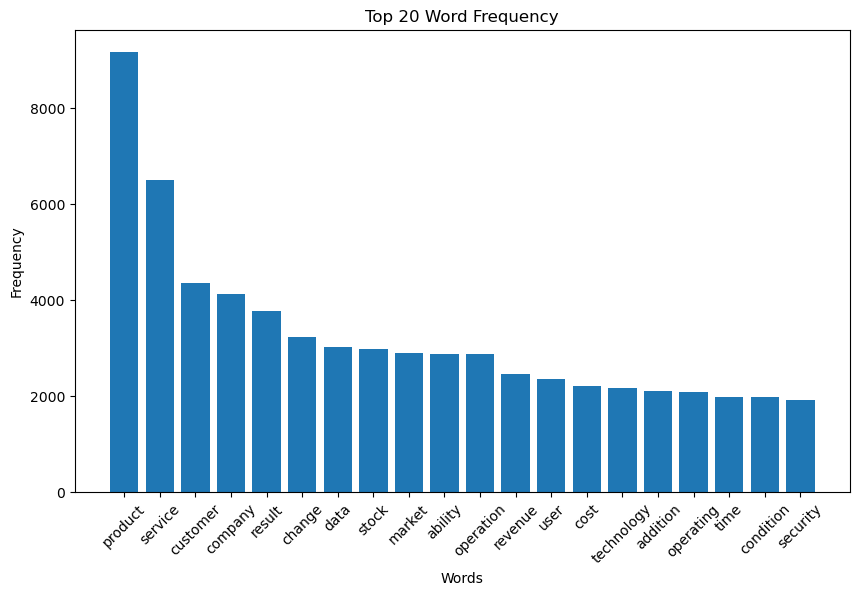

In [127]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()

# Fit and transform the data
X = count_vectorizer.fit_transform(cleaned_sample)

# Sum the word counts across all documents
word_freq = dict(zip(count_vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))
sorted_word_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))

# Plotting the top 20 word frequency
plt.figure(figsize=(10, 6))
plt.bar(list(sorted_word_freq.keys())[:20], list(sorted_word_freq.values())[:20])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Word Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=.8,min_df=5,ngram_range = (1,1),stop_words=stopWords)

vector = vectorizer.fit_transform(cleaned_sample)
print(vector.shape)
vocab = vectorizer.vocabulary_
vocab


(14341, 2129)


{'operation': 1347,
 'uncertainty': 1999,
 'information': 1007,
 'report': 1634,
 'form': 825,
 'section': 1728,
 'managements': 1185,
 'discussion': 597,
 'analysis': 83,
 'financial': 796,
 'condition': 366,
 'results': 1663,
 'operations': 1348,
 'statement': 1829,
 'note': 1308,
 'investment': 1069,
 'decision': 498,
 'one': 1339,
 'occurrence': 1324,
 'case': 243,
 'trading': 1960,
 'price': 1480,
 'stock': 1839,
 'disclosure': 589,
 'revenue': 1672,
 'growth': 891,
 'performance': 1416,
 'operating': 1346,
 'history': 923,
 'year': 2121,
 'january': 1087,
 'ability': 1,
 'obligation': 1319,
 'percentage': 1414,
 'period': 1417,
 'number': 1313,
 'platform': 1442,
 'consumption': 400,
 'reason': 1570,
 'competition': 340,
 'change': 266,
 'technology': 1911,
 'software': 1789,
 'infrastructure': 1008,
 'demand': 532,
 'customer': 474,
 'budget': 213,
 'cash': 244,
 'flow': 808,
 'management': 1184,
 'contract': 414,
 'duration': 645,
 'response': 1657,
 'addition': 28,
 'pace': 13

In [123]:
sorted_vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)
top_words = sorted_vocab[:20]
top_words

[('zuckerberg', 2128),
 ('zscaler', 2127),
 ('zoning', 2126),
 ('zero', 2125),
 ('youtube', 2124),
 ('york', 2123),
 ('yield', 2122),
 ('year', 2121),
 ('yahoo', 2120),
 ('xeon', 2119),
 ('xbox', 2118),
 ('worth', 2117),
 ('worm', 2116),
 ('worldwide', 2115),
 ('world', 2114),
 ('workstation', 2113),
 ('workspace', 2112),
 ('workplace', 2111),
 ('workload', 2110),
 ('workforce', 2109)]

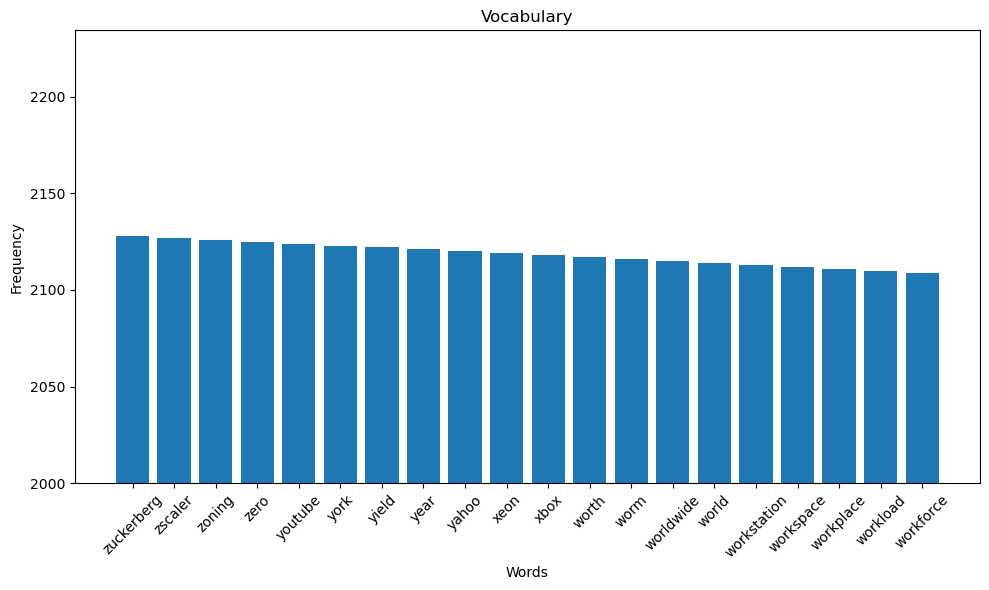

In [98]:

sorted_vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)
top_words = sorted_vocab[:20]
words = [item[0] for item in top_words]
counts = [item[1] for item in top_words]

plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Vocabulary')
plt.ylim(2000,)
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.savefig('vocabulary_bar.png')
plt.show()

In [99]:
terms = vectorizer.get_feature_names_out()
terms

array(['abatement', 'ability', 'abrupt', ..., 'zoning', 'zscaler',
       'zuckerberg'], dtype=object)

<Figure size 1000x600 with 0 Axes>

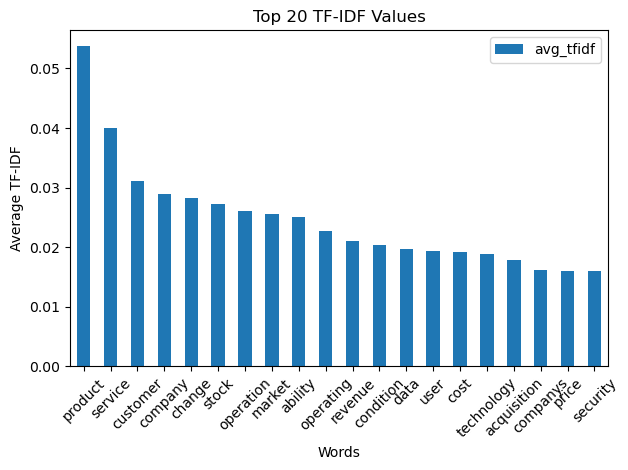

In [100]:
# Calculate average TF-IDF values
avg_tfidf = vector.mean(axis=0)

avg_tfidf_df = pd.DataFrame(avg_tfidf.T, index=vectorizer.get_feature_names_out(), columns=['avg_tfidf'])

# Sort the DataFrame by 'avg_tfidf' column in descending order
avg_tfidf_df = avg_tfidf_df.sort_values(by='avg_tfidf', ascending=False)

# Plotting the top n average TF-IDF values as a bar plot
top_20_tfidf = avg_tfidf_df.head(20)

plt.figure(figsize=(10, 6))
top_20_tfidf.plot(kind='bar')
plt.title('Top 20 TF-IDF Values')
plt.xlabel('Words')
plt.ylabel('Average TF-IDF')
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.savefig('top_tfidf_values.png')
plt.show()


### LDA Model Training

In [101]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
lda_model = LDA(n_components=5, random_state=42)
lda_model.fit(vector)
lda_model.components_


array([[  0.21295994,  16.77984662,   0.20000552, ...,   0.20088995,
          0.20000988,   0.20002454],
       [  0.20004122,  69.84771135,   0.20041552, ...,   0.20025152,
          0.20354404,   0.20002228],
       [  0.21555629,  64.58362522,   1.09147089, ...,   0.20047568,
          0.88294469,   0.20000914],
       [  0.20003475,  75.17672065,   0.20000545, ...,   0.20002096,
          0.20002457,  11.86888129],
       [  1.97075335, 133.63191202,   0.20000568, ...,   2.67909849,
          0.20001062,   0.20000775]])

In [102]:
categories = {}

for i, comp in enumerate(lda_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:7]
    out = "Topic " + str(i) + ": "
    for t in sorted_terms:
        out = out + t[0] + " "
    categories[i] = out

# Print the dictionary of topic terms
print(categories)

{0: 'Topic 0: law change regulation rate liability currency data ', 1: 'Topic 1: operation security condition system operating company data ', 2: 'Topic 2: customer product service revenue demand offering cloud ', 3: 'Topic 3: stock acquisition price stockholder dell director class ', 4: 'Topic 4: product service user property right ability content '}


In [103]:
for value in categories.values():
    print(value)

Topic 0: law change regulation rate liability currency data 
Topic 1: operation security condition system operating company data 
Topic 2: customer product service revenue demand offering cloud 
Topic 3: stock acquisition price stockholder dell director class 
Topic 4: product service user property right ability content 


In [104]:
#!pip install pyldavis   

import pyLDAvis.lda_model

pyLDAvis.enable_notebook()

In [105]:
vis = pyLDAvis.lda_model.prepare(lda_model, vector, vectorizer)
pyLDAvis.display(vis)

# Step 4: Tag the risks with topics
### Loop through each row (10K filing) and assign a topic to each individual risk statement

In [106]:
# Initialize an empty list to store the tags for each row
tags_list = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Split the cleaned risks text into individual documents
    sample = row['cleaned_risks'].split('\n')
    
    # Fit TF-IDF values on each filing
    vector = vectorizer.transform(sample)
    
    # Obtain document-topic distribution from the LDA model
    doc_topic_distribution = lda_model.transform(vector)
    
    # Categorize documents
    document_categories = []
    for doc_topic_dist in doc_topic_distribution:
        dominant_topic = max(enumerate(doc_topic_dist), key=lambda x: x[1])[0]
        category = categories.get(dominant_topic, "Other")
        document_categories.append(category)
    
    # Append the document categories to the tags list
    tags_list.append('\n'.join(document_categories))

# Assign the tags to the DataFrame
df['tags'] = tags_list

# Step 5: Fetch tags for a doc
### Use this code to fetch the tagged risks for a 10k

In [22]:
def fetch_tags(doc_index):
    risks = df.loc[doc_index,'risks'].split('\n')
    tags =  df.loc[doc_index,'tags'].split('\n')

    for i in range(len(risks)):
        print(risks[i],' - ',tags[i],'\n')

In [23]:
fetch_tags(0)

Our operations and financial results are subject to various risks and uncertainties, including those described below. You should consider and read carefully all of the risks and uncertainties described below, together with all of the other information contained in this Annual Report on Form 10-K, including the section titled Managements Discussion and Analysis of Financial Condition and Results of Operations and our consolidated financial statements and related notes, before making an investment decision. The risks described below are not the only ones we face. The occurrence of any of the following risks or additional risks and uncertainties not presently known to us or that we currently believe to be immaterial could materially and adversely affect our business, financial condition, or results of operations. In such case, the trading price of our common stock could decline. You should not interpret our disclosure of any of the following risks to imply that such risks have not already

In [122]:
#pip install -q transformers

data = df['risks'].str.split('\n').explode().tolist()


from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
data = data[20:22]
print([print(d,'\n') for d in data])
sentiment_pipeline(data)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


If we are unable to enhance our platform or operations to keep pace with these rapidly evolving customer requirements, or if new technologies emerge that are able to deliver competitive products at lower prices, more efficiently, more conveniently, or more securely than our platform, our business, financial condition, and results of operations could be adversely affected.  

If we or our third-party service providers experience an actual or perceived security breach or unauthorized parties otherwise obtain access to our customers data, our data, or our platform, our platform may be perceived as not being secure, our reputation may be harmed, demand for our platform may be reduced, and we may incur significant liabilities.  

[None, None]


[{'label': 'NEGATIVE', 'score': 0.9975973963737488},
 {'label': 'NEGATIVE', 'score': 0.9993981122970581}]